In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [2]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train/VASC 3488
data/train/BCC 4773
data/train/MEL 3308
data/train/DF 4152
data/train/BKL 3275
data/train/NV 4975
data/train/AKIEC 3856


In [5]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation/VASC 1484
data/validation/BCC 1692
data/validation/MEL 1664
data/validation/DF 1632
data/validation/BKL 1479
data/validation/NV 1730
data/validation/AKIEC 1552


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


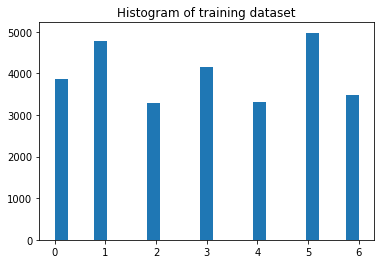

In [50]:
plt.hist(train_generator.classes, bins='auto') 
plt.title("Histogram of training dataset")
plt.show()

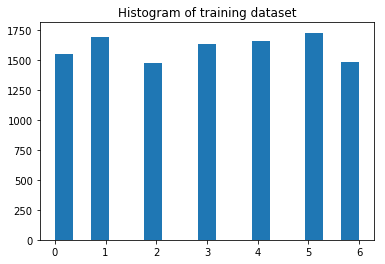

In [55]:
plt.hist(validation_generator.classes, bins='auto') 
plt.title("Histogram of training dataset")
plt.show()

In [7]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [8]:
## Intilizing variables
output_classes = 7

batch_size = 32 
epochs = 50
droput_rate= 0.5

adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
vgg16_weights= 'pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model = (VGG16(include_top=False, pooling='avg', weights=vgg16_weights))
x = model.output
# x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
model = Model(input = model.input, output = predictions)


model.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics = ["categorical_accuracy", fmeasure, recall, precision])


In [12]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50
2048/2048 [==============================] - 828s 404ms/step - loss: 1.5045 - categorical_accuracy: 0.5756 - fmeasure: 0.5640 - recall: 0.5140 - precision: 0.6305 - val_loss: 1.1727 - val_categorical_accuracy: 0.6711 - val_fmeasure: 0.6724 - val_recall: 0.6280 - val_precision: 0.7253
Epoch 2/50
2048/2048 [==============================] - 819s 400ms/step - loss: 0.7167 - categorical_accuracy: 0.8058 - fmeasure: 0.8057 - recall: 0.7780 - precision: 0.8366 - val_loss: 1.9394 - val_categorical_accuracy: 0.5848 - val_fmeasure: 0.5889 - val_recall: 0.5732 - val_precision: 0.6062
Epoch 3/50
2048/2048 [==============================] - 820s 401ms/step - loss: 0.4389 - categorical_accuracy: 0.8949 - fmeasure: 0.8954 - recall: 0.8828 - precision: 0.9089 - val_loss: 0.6998 - val_categorical_accuracy: 0.8407 - val_fmeasure: 0.8419 - val_recall: 0.8310 - val_precision: 0.8535
Epoch 4/50
2048/2048 [==============================] - 821s 401ms/step - loss: 0.2905 - categorical_accuracy: 0

Epoch 29/50
2048/2048 [==============================] - 820s 400ms/step - loss: 0.0720 - categorical_accuracy: 0.9984 - fmeasure: 0.9984 - recall: 0.9984 - precision: 0.9984 - val_loss: 0.8165 - val_categorical_accuracy: 0.8901 - val_fmeasure: 0.8904 - val_recall: 0.8891 - val_precision: 0.8918
Epoch 30/50
2048/2048 [==============================] - 821s 401ms/step - loss: 0.0713 - categorical_accuracy: 0.9986 - fmeasure: 0.9985 - recall: 0.9985 - precision: 0.9986 - val_loss: 0.7665 - val_categorical_accuracy: 0.8989 - val_fmeasure: 0.8993 - val_recall: 0.8981 - val_precision: 0.9004
Epoch 31/50
2048/2048 [==============================] - 821s 401ms/step - loss: 0.0701 - categorical_accuracy: 0.9986 - fmeasure: 0.9986 - recall: 0.9986 - precision: 0.9986 - val_loss: 0.7816 - val_categorical_accuracy: 0.8966 - val_fmeasure: 0.8966 - val_recall: 0.8950 - val_precision: 0.8983
Epoch 32/50
2048/2048 [==============================] - 822s 401ms/step - loss: 0.0678 - categorical_accurac

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  0.8115412543714047
Test Accuracy:  0.9025
fmeasure:  0.9023511290550232
Recall:  0.90125
Precision:  0.903487901687622


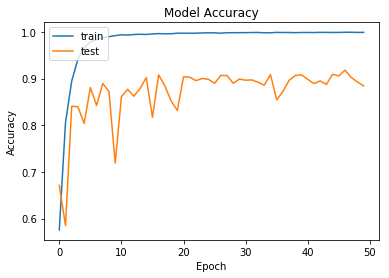

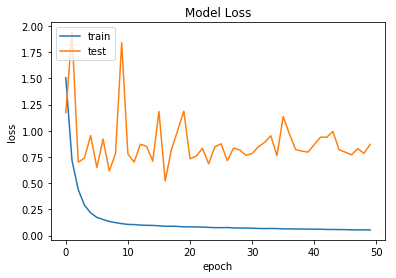

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

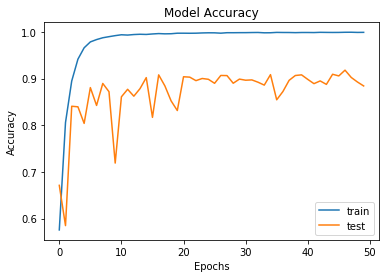

In [18]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

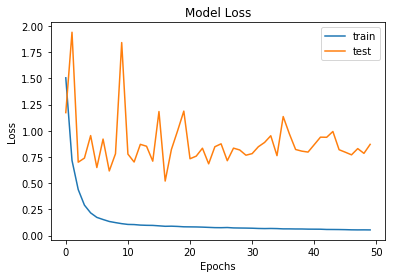

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

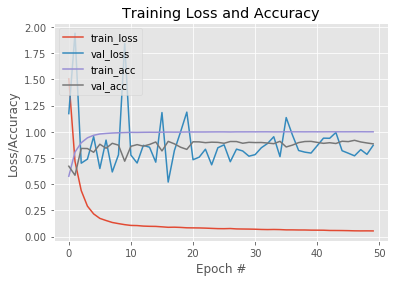

In [20]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [10]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [11]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

352/351 [==============================] - 2803s 8s/step
No of errors = 1305/11233


Confusion Matrix
[[1329   74  126    0   19    4    0]
 [  11 1645   33    0    1    2    0]
 [   7    3 1447    0    5   17    0]
 [  17   91   89 1397   21   17    0]
 [   5   10  123    1 1448   77    0]
 [   2   13   86    1   35 1592    1]
 [   0   37   24   12    4  337 1070]]


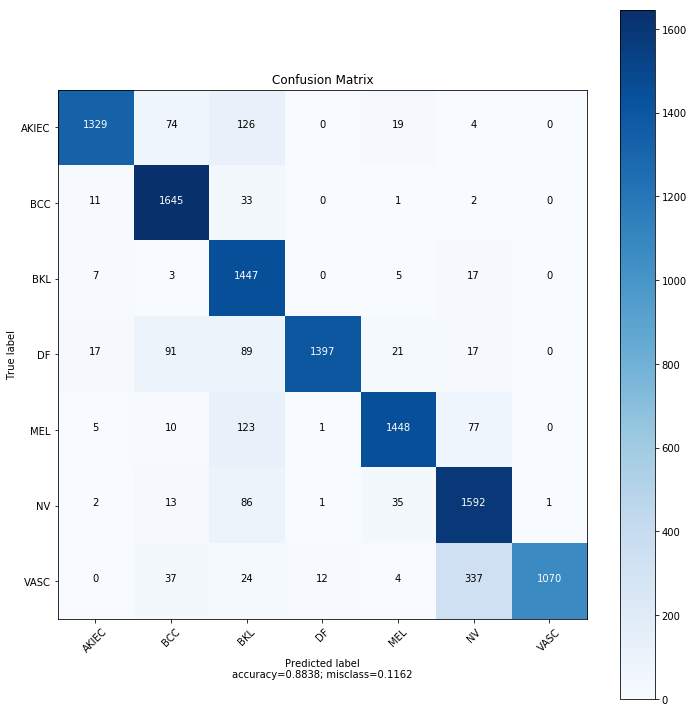

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/5.VGG16-CM.png', bbox_inches='tight', dpi = 100)

plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

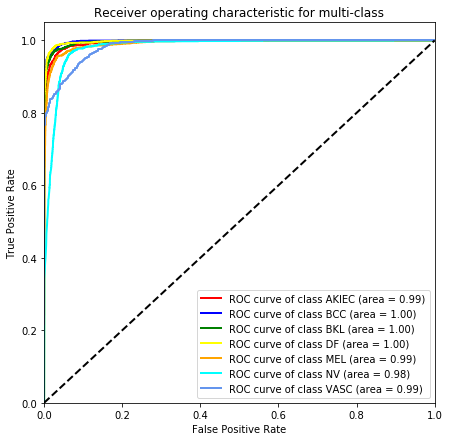

In [14]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle


y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = validation_generator.classes

classnames=[]
for classname in validation_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4,5,6])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=7
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

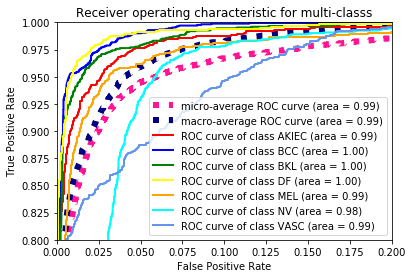

In [15]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=6)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=6)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")
plt.savefig('plots/5.VGG16-ROC.png')
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report



confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[1329   74  126    0   19    4    0]
 [  11 1645   33    0    1    2    0]
 [   7    3 1447    0    5   17    0]
 [  17   91   89 1397   21   17    0]
 [   5   10  123    1 1448   77    0]
 [   2   13   86    1   35 1592    1]
 [   0   37   24   12    4  337 1070]]
             precision    recall  f1-score   support

      AKIEC       0.97      0.86      0.91      1552
        BCC       0.88      0.97      0.92      1692
        BKL       0.75      0.98      0.85      1479
         DF       0.99      0.86      0.92      1632
        MEL       0.94      0.87      0.91      1664
         NV       0.78      0.92      0.84      1730
       VASC       1.00      0.72      0.84      1484

avg / total       0.90      0.88      0.88     11233



In [73]:
roc_auc

{0: 0.9949088886510615,
 1: 0.9977411472646484,
 2: 0.9961727183785352,
 3: 0.997299543450335,
 4: 0.9917699231090781,
 5: 0.9813491206610142,
 6: 0.9854240354736776,
 'micro': 0.98777243514899,
 'macro': 0.9921056265820095}

In [76]:
roc_auc["macro"]

0.9921056265820095

In [9]:
from keras.models import load_model
model = load_model("models/5.VGG16-Adam-Dropout-Model.h5", custom_objects={'fmeasure': fmeasure,  'recall': recall, 'precision': precision })
model.load_weights("models/g.VGG16-Adam-Dropout-Weights.h5")

In [24]:
model.save('models/5.VGG16-Adam-Dropout-Model.h5')
model.save_weights('models/g.VGG16-Adam-Dropout-Weights.h5')

In [ ]:
model.save('models/5.VGG16-2-Adam-Dropout-Model.h5')
model.save_weights('models/5.VGG16-2-Adam-Dropout-Weights.h5')